# LSTM implementation for the centralized model 

In [154]:
# Dataset - 2019
# Imputation tech - KNN for both air pollutants and meteorological data
# Evaluation metric - MAE while training and SMAPE metric for validating test data
# Negative values where not replaced

In [155]:
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [156]:
from numpy import split
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,GRU,Conv2D,MaxPool1D,Conv1D,MaxPooling1D,AveragePooling1D
from keras.layers import Bidirectional
from keras.layers import TimeDistributed,Dropout,RepeatVector
from keras.layers import recurrent

In [157]:
#Read the dataset based on the station id
# path = "Uppsala\\Sem 3\\Dataset\\2014-2018_combined\\18644\\KNN_18644_2015_2018.xlsx" 
# path = "output_Gade_Weather.csv"
# path = "Aalborg_Gade_Weather_finalMoreData.csv"
path = "Aalborg_Tag_Weather_Final.csv"

df_data = pd.read_csv(path)
# file_name = os.path.join("C:\\",path)


# df_2015_2019_data = pd.read_excel(file_name)

# df_2015_2019_data
df_data

,Start,NO2,NOX,O3,heat_index,rh,pressure,wdir,wdir_cardinal,wspd,station_id
0,2019-12-06 10:00:00,6.43,8.06,69.81,9.0,87.0,992.65,260.0,W,31.0,Tag
1,2019-12-06 10:30:00,9.36,11.62,64.26,9.0,87.0,993.65,260.0,W,33.0,Tag
2,2019-12-06 11:00:00,10.42,13.22,62.80,8.0,93.0,993.65,250.0,WSW,33.0,Tag
3,2019-12-06 11:30:00,9.28,12.08,64.50,8.0,93.0,993.65,250.0,WSW,30.0,Tag
4,2019-12-06 12:00:00,13.09,17.45,57.96,8.0,93.0,993.65,250.0,WSW,24.0,Tag
...,...,...,...,...,...,...,...,...,...,...,...
39457,2022-03-07 10:30:00,6.96,9.64,69.91,-1.0,100.0,1026.63,230.0,SW,7.0,Tag
39458,2022-03-07 11:00:00,8.89,12.76,67.22,2.0,93.0,1026.63,230.0,SW,13.0,Tag
39459,2022-03-07 11:30:00,7.90,11.25,69.61,2.0,100.0,1026.63,240.0,WSW,17.0,Tag
39460,2022-03-07 12:00:00,14.91,20.59,54.56,2.0,100.0,1026.63,260.0,W,17.0,Tag


In [158]:
# Dropping some weather features, adding time features and converting them into one-hot encoded values

# df_2015_2019 = df_2015_2019_data.copy()
# df_2015_2019 = df_2015_2019.drop(columns=['Relative humidity','Air pressure','Wind speed','Wind direction'])
# lstm_df = df_2015_2019.copy()  
df = df_data.copy()
#Keeping heat index and relative humidity features
df = df.drop(columns=['wdir_cardinal', 'station_id'])
# df = df.drop(columns=['O3','wdir_cardinal','station_id'])

lstm_df = df.copy()

# Add time related features
lstm_df['Weekday'] = pd.to_datetime(df['Start']).dt.day_name()
lstm_df['Hour'] = pd.to_datetime(df['Start']).dt.hour
# lstm_df['Minutes'] = pd.to_datetime(df['Start']).dt.minute

# lstm_df['Weekday'] = df_2015_2019['Start'].dt.day_name()
##lstm_df['Day_num'] = df_2017_2019['Start'].dt.day
# lstm_df['Hour'] = df_2015_2019['Start'].dt.hour
##lstm_df['Quarter'] = df_2017_2019['Start'].dt.quarter

label_encoder_1 = LabelEncoder()
onehot_encoder_1 = OneHotEncoder(sparse=False)

#label_encoder_2 = LabelEncoder()
#onehot_encoder_2 = OneHotEncoder(sparse=False)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Weekday'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Weekday'] = onehot_encoder_1.fit_transform(integer_encoded)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Hour'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Hour'] = onehot_encoder_1.fit_transform(integer_encoded)

# integer_encoded = label_encoder_1.fit_transform(lstm_df['Minutes'])
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# lstm_df['Minutes'] = onehot_encoder_1.fit_transform(integer_encoded)

# Remove timestamp attribute
date_time = lstm_df.pop('Start')

# Replacing negative values with zeros
#lstm_df.PM10=lstm_df.PM10.mask(lstm_df.PM10.lt(0),0)

# Use first 9 months for training and validation sets for 2019
# train_data = lstm_df[0:41616] #lstm_df[0:24072] #train_data = lstm_df[0:6552]
train_data = lstm_df[0:35520] #lstm_df[0:30432] #lstm_df[0:24072] #train_data = lstm_df[0:6552]

# train_df = train_data[0:32856] #train_data[0:35064] #train_data[0:19680] #train_data[0:5088] # Training set - January - August months
# val_df = train_data[32856:] #train_data[35064:] #train_data[19680:] #train_data[5088:] # Validation set - September month
train_df = train_data[0:28416] #train_data[0:24336] #train_data[0:35064] #train_data[0:19680] #train_data[0:5088] # Training set - January - August months
val_df = train_data[28416:]  #train_data[24336:] #train_data[35064:] #train_data[19680:] #train_data[5088:] # Validation set - September month

# Use Oct-Dec months for Testing set
test_df = lstm_df[35520: -6] #lstm_df[24072:] #lstm_df[6552:]

num_features = lstm_df.shape[1]

In [159]:
lstm_df.shape

(39462, 10)

In [160]:
lstm_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,39462.0,7.676126,5.451885,-0.66,3.68,6.23,10.38,39.11
NOX,39462.0,9.126460,7.744576,-4.12,4.11,7.03,11.94,70.32
O3,39462.0,55.189450,19.077164,0.00,42.76,58.81,69.81,86.01
heat_index,39462.0,8.732553,6.472370,-13.00,4.00,8.00,14.00,30.00
rh,39462.0,83.350109,14.995676,25.00,76.00,87.00,93.00,100.00
pressure,39462.0,1011.350680,11.972571,964.66,1003.64,1012.64,1019.64,1041.63
wdir,39462.0,200.611981,87.455915,10.00,130.00,220.00,270.00,360.00
wspd,39462.0,17.432593,10.393237,0.00,9.00,17.00,24.00,72.00
Weekday,39462.0,0.143024,0.350101,0.00,0.00,0.00,0.00,1.00
Hour,39462.0,0.041660,0.199814,0.00,0.00,0.00,0.00,1.00


In [161]:
# Normalize the datasets using mean and std_deviation
lst = list(df.columns) #list(combined_data.columns)
lst.remove('Start')
print(lst)

train_mean = train_df[lst].mean()
train_std = train_df[lst].std()

training_set = (train_df[lst] - train_mean) / train_std
validation_set = (val_df[lst] - train_mean) / train_std
testing_set = (test_df[lst] - train_mean) / train_std

time_ftrs = set(list(lstm_df.columns)) - set(lst)
time_ftrs = list(time_ftrs)

training_set[time_ftrs] = train_df[time_ftrs]
validation_set[time_ftrs] = val_df[time_ftrs]
testing_set[time_ftrs] = test_df[time_ftrs]

columnsTitles = list(sorted(set(lst), key=lst.index) + sorted(set(time_ftrs), key=time_ftrs.index))

training_set = training_set.reindex(columns=columnsTitles)
validation_set = validation_set.reindex(columns=columnsTitles)
testing_set = testing_set.reindex(columns=columnsTitles)

['NO2', 'NOX', 'O3', 'heat_index', 'rh', 'pressure', 'wdir', 'wspd']


In [162]:
print(training_set.shape,validation_set.shape,testing_set.shape)

(28416, 10) (7104, 10) (3936, 10)


In [163]:
training_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,28416.0,1.600321e-17,1.000000,-1.554510,-0.733796,-0.268975,0.500093,5.914552
NOX,28416.0,2.400482e-17,1.000000,-1.711168,-0.640366,-0.273048,0.359050,7.950715
O3,28416.0,4.800964e-17,1.000000,-3.010019,-0.587098,0.203769,0.773743,1.546069
heat_index,28416.0,0.000000e+00,1.000000,-3.345621,-0.741322,-0.128546,0.790618,3.241723
rh,28416.0,4.400884e-16,1.000000,-3.642842,-0.520343,0.308076,0.690422,1.136494
pressure,28416.0,2.072616e-14,1.000000,-3.905342,-0.570862,0.096367,0.680193,2.514240
wdir,28416.0,5.601125e-17,1.000000,-2.139398,-0.787325,0.226729,0.790093,1.804148
wspd,28416.0,1.040209e-16,1.000000,-1.661519,-0.801713,-0.037442,0.631295,4.739252
Hour,28416.0,4.166667e-02,0.199830,0.000000,0.000000,0.000000,0.000000,1.000000
Weekday,28416.0,1.428773e-01,0.349954,0.000000,0.000000,0.000000,0.000000,1.000000


Index(['NO2', 'NOX', 'O3', 'heat_index', 'rh', 'pressure', 'wdir', 'wspd',
       'Weekday', 'Hour'],
      dtype='object')

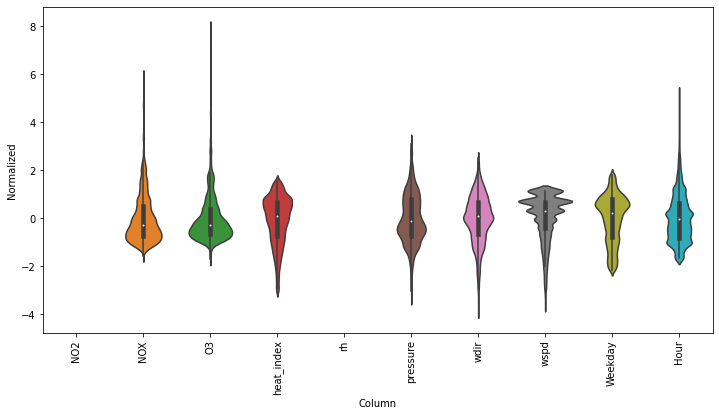

In [164]:
# Visualization of normalized values
df_std = (lstm_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(lstm_df.keys(), rotation=90)
lstm_df.keys()

In [165]:
# Metric - Mean Absolute Percentage Error suggested by Shengui Li
def smape(y_true, y_pred):
    return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                         / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

In [166]:
# Group the timestamp dataset into days format
def split_dataset(train,val,test):
    # split into days and restructure into windows of daily data
    train = array(split(train, len(train)/48))
    val = array(split(val, len(val)/48))
    test = array(split(test, len(test)/48))
    return train,val,test


In [167]:
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)
print("Data format: [Samples,Timesteps,Features]")
print('Training data:',train.shape,'\nValidation data:',val.shape,'\nTesting data:',test.shape)

Data format: [Samples,Timesteps,Features]
Training data: (592, 48, 10) 
Validation data: (148, 48, 10) 
Testing data: (82, 48, 10)


In [168]:
# convert history into inputs and outputs format of 24 hours history and 24 hours forecast
def to_supervised(train, n_input=48, n_out=48):
    # flatten data into timestamps data format
    # 507 * 48, 7
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0:3]) # Change the 2nd dimension according to the num of features to be predicted 
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [184]:
# Build the LSTM model architecture and train the model
def build_model(train,val,n_input,n_out_features):
    
    # prepare the training and validation data by sequencing them as window of 24 hours data 
    train_x, train_y = to_supervised(train, n_input)
    val_x, val_y = to_supervised(val,n_input)
    
    # define the model parameters
    verbose, epochs, batch_size = 2, 90, 256
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # define the model architecture
    model = Sequential()
    
    # # Single feature prediction
    # model.add(LSTM(50, activation='relu',input_shape=(n_timesteps, n_features)))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
    
    # Multi features predictions
    # model.add(LSTM(50, activation='relu',
    #           input_shape=(n_timesteps, n_features)))
    # model.add(Attention(name='attention_weight'))
    # model.add(Dropout(0.50))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.50))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #CNN + LSTM
    #Filters detects patterns
    #Each conv1d is a convolutional layer (hidden layer)
    # A convolutinal layer recieves input, transforms it and outputs it to the next layer
    # model.add(Conv1D(filters=6, kernel_size=2,
    #                  strides=1, 
    #                  padding="same",
    #                  activation="tanh",
    #                  input_shape=[n_timesteps, n_features])),
    # model.add(Conv1D(filters=16, kernel_size=2,
    #                  strides=1,padding="valid",
    #                  activation="tanh"))
    # model.add(AveragePooling1D()),
    
    model.add(LSTM(35, activation='tanh', recurrent_activation="sigmoid", input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.30))
    model.add(Dense(90, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(n_outputs*n_out_features))
    model.add(Dropout(0.30))
    model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #LSTM model
    # model.add(LSTM(25, activation='relu', input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.20))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.20))
    # model.add((Dense(n_outputs*n_out_features)))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))

    # model.add(LSTM(25, activation='relu',
    #           input_shape=(n_timesteps, n_features)))
    # # model.add(Dropout(0.2))
    # model.add(Dense(35, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(Dropout(0.2))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))


    
    #GRU
    # model.add(GRU(10, activation='relu', ,
    #          input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.3))
    # model.add(Dense(80, activation='relu'))
    # # model.add(Dropout(0.50))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    
    #Bi-directional LSTMS
    #model.add(Bidirectional(LSTM(50,return_sequences=True,
    #                       input_shape=(n_timesteps, n_features))))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(TimeDistributed(Dense(n_out_features)))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    model.compile(loss='mae', optimizer='adam')
    
    # fit the network
    history = model.fit(train_x, train_y, epochs=epochs, 
                        batch_size=batch_size,shuffle=False,
                        validation_data=(val_x, val_y),
                        callbacks=[early_stopping],
                        verbose=verbose)
    
    # Plot the validation loss and training loss 
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()


        # Feature importance:
    results = []
    print(' Computing LSTM Feature importance...')
    feature_preds = model.predict(val_x, verbose = 0).squeeze()
    baseline_mae = np.mean(np.abs(feature_preds - val_y))
    results.append({'feature': 'BASELINE', 'mae': baseline_mae})

    for i in range(len(columnsTitles)):
        save_col = val_x[:,:,i].copy()
        np.random.shuffle(val_x[:,:,i])

        feature_preds = model.predict(val_x, verbose = 0).squeeze()
        mae = np.mean(np.abs(feature_preds - val_y))
        results.append({'feature': columnsTitles[i], 'mae': mae})
        val_x[:,:,i] = save_col
    
    print()
    width = [0.2]
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(5,5))
    plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
    plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,len(columnsTitles)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                     label=f'Baseline \nMAE={baseline_mae:.3f}')
    plt.xlabel('MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
    
    return model

In [185]:
# Make a forecast for next 24 hours
def forecast(model, history, n_input):
    # flatten the data into timestamps format
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations i.e last 24 hours for input data 
    input_x = data[-n_input:, :]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next day
    yhat = model.predict(input_x, verbose=2)
    model.save('tf_lstm_model_Tag.h5')  
    return yhat[0]

In [186]:
# Evaluate the model
def evaluate_model(train,val,test, n_input,n_out_features):
    # fit model
    model = build_model(train,val,n_input,n_out_features)
    model.summary()
    # history is a list of daily data
    history = [x for x in val] #train]
    # walk-forward validation over each day  
    predictions = list()
    for i in range(len(test)):
        # predict the next day
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next day
        history.append(test[i, :])
    # evaluate predictions days for each day
    predictions = array(predictions)
    return predictions

Epoch 1/90
111/111 - 4s - loss: 0.7062 - val_loss: 0.7089
Epoch 2/90
111/111 - 4s - loss: 0.6634 - val_loss: 0.6597
Epoch 3/90
111/111 - 4s - loss: 0.6504 - val_loss: 0.6428
Epoch 4/90
111/111 - 4s - loss: 0.6399 - val_loss: 0.6331
Epoch 5/90
111/111 - 4s - loss: 0.6292 - val_loss: 0.6226
Epoch 6/90
111/111 - 4s - loss: 0.6217 - val_loss: 0.6161
Epoch 7/90
111/111 - 4s - loss: 0.6160 - val_loss: 0.6108
Epoch 8/90
111/111 - 4s - loss: 0.6114 - val_loss: 0.6056
Epoch 9/90
111/111 - 4s - loss: 0.6074 - val_loss: 0.6037
Epoch 10/90
111/111 - 4s - loss: 0.6040 - val_loss: 0.6000
Epoch 11/90
111/111 - 4s - loss: 0.6007 - val_loss: 0.5994
Epoch 12/90
111/111 - 4s - loss: 0.5988 - val_loss: 0.5968
Epoch 13/90
111/111 - 4s - loss: 0.5968 - val_loss: 0.5954
Epoch 14/90
111/111 - 4s - loss: 0.5944 - val_loss: 0.5946
Epoch 15/90
111/111 - 4s - loss: 0.5924 - val_loss: 0.5940
Epoch 16/90
111/111 - 4s - loss: 0.5906 - val_loss: 0.5935
Epoch 17/90
111/111 - 4s - loss: 0.5888 - val_loss: 0.5926
Epoch 

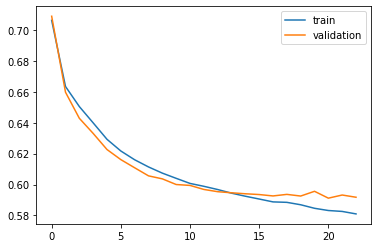

 Computing LSTM Feature importance...



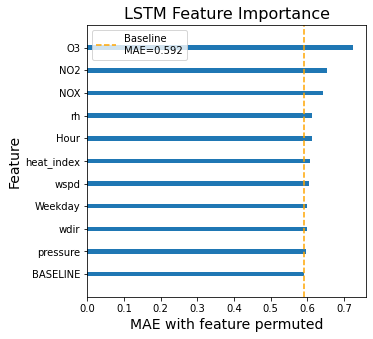

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 35)                6440      
_________________________________________________________________
dense_18 (Dense)             (None, 90)                3240      
_________________________________________________________________
dropout_18 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 144)               13104     
_________________________________________________________________
dropout_19 (Dropout)         (None, 144)               0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 48, 3)             0         
Total params: 22,784
Trainable params: 22,784
Non-trainable params: 0
__________________________________________________

In [187]:
# Main program starts from here - Firstly split the timestamp data into days format
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)

n_input = 48   # Number of previous timestamps needed to predict future data
n_out_features = 3  # features to be predicted [NO2,NOX as NO2, PM10 and PM2.5]

predictions = evaluate_model(train,val,test, n_input,n_out_features)

In [173]:
predictions.shape

(82, 48, 3)

# Collect the predicted values for the 2 pollutants, denormalize the values and calculate the SMAPE scores

In [174]:
# # print(predictions.shape)
# from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error 
# # Predictions for NO2, NOX as NO2, PM10 and PM2.5

# pred_de_norm = {}
# grnd_de_norm = {}
# smape_scores = {}
# avg_smape_score = 0 

# df_write = pd.DataFrame(columns=['NO2','NOX'])
# df_write1 = pd.DataFrame(columns=['NO2','NOX'])

# n_out = 48
# for i in range(0,2):
    
#     # Denormalize the predicted values
#     #pred_de_norm[i] = ( predictions[:,:,i] * train_std[i] ) + train_mean[i]
#     #grnd_de_norm[i] = ( test[:,:n_out,i] * train_std[i] ) + train_mean[i]
    
#     pred_de_norm[i] = predictions[:,:,i]
#     grnd_de_norm[i] = test[:,:n_out,i]
    
#     # Reshape into 1D array
#     grnd_de_norm[i] = grnd_de_norm[i].reshape(grnd_de_norm[i].shape[0]*grnd_de_norm[i].shape[1])
#     pred_de_norm[i] = pred_de_norm[i].reshape(pred_de_norm[i].shape[0]*pred_de_norm[i].shape[1])

#     pred_de_norm[i] = pred_de_norm[i].astype('float32')
#     grnd_de_norm[i] = grnd_de_norm[i].astype('float32')
    
#     #smape_scores[i] = smape(grnd_de_norm[i],pred_de_norm[i])
#     smape_scores[i] = mean_absolute_error(grnd_de_norm[i],pred_de_norm[i]) 
    
#     avg_smape_score = avg_smape_score + smape_scores[i]
    
#     col = df_write.columns[i]
#     col1 = df_write1.columns[i]

#     df_write[col] = pred_de_norm[i]
#     df_write1[col1] = grnd_de_norm[i]
    
# #df_write.insert(loc=0, column='Start', value=date_time[41616:].values)
# avg_smape_score = avg_smape_score / 2
# print("\nSmape score for all 2 pollutants:",smape_scores)
# print("\nAverage smape score:",avg_smape_score)

In [188]:
# print(predictions.shape)
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
# Predictions for NO2, NOX as NO2, PM10 and PM2.5

pred_de_norm = {}
grnd_de_norm = {}
pred_norm = {}
grnd_norm = {}
mae_scores = {}
avg_mae_score = 0 

df_write = pd.DataFrame(columns=['NO2','NOX','O3'])
df_write1 = pd.DataFrame(columns=['NO2','NOX','O3'])

n_out = 48
for i in range(0,3):
    
    # Denormalize the predicted values
    pred_norm[i] = ( predictions[:,:,i] * train_std[i] ) + train_mean[i]
    grnd_norm[i] = ( test[:,:n_out,i] * train_std[i] ) + train_mean[i]
    
    pred_de_norm[i] = predictions[:,:,i]
    grnd_de_norm[i] = test[:,:n_out,i]
    
    # Reshape into 1D array for normal values
    grnd_norm[i] = grnd_norm[i].reshape(grnd_norm[i].shape[0]*grnd_norm[i].shape[1])
    pred_norm[i] = pred_norm[i].reshape(pred_norm[i].shape[0]*pred_norm[i].shape[1])

    pred_norm[i] = pred_norm[i].astype('float32')
    grnd_norm[i] = grnd_norm[i].astype('float32')
    
    # Reshape into 1D array
    grnd_de_norm[i] = grnd_de_norm[i].reshape(grnd_de_norm[i].shape[0]*grnd_de_norm[i].shape[1])
    pred_de_norm[i] = pred_de_norm[i].reshape(pred_de_norm[i].shape[0]*pred_de_norm[i].shape[1])

    pred_de_norm[i] = pred_de_norm[i].astype('float32')
    grnd_de_norm[i] = grnd_de_norm[i].astype('float32')
    
    #smape_scores[i] = smape(grnd_de_norm[i],pred_de_norm[i])
    mae_scores[i] = mean_absolute_error(grnd_norm[i],pred_norm[i]) 
    
    avg_mae_score = avg_mae_score + mae_scores[i]
    
    col = df_write.columns[i]
    col1 = df_write1.columns[i]

    df_write[col] = pred_norm[i]
    df_write1[col1] = grnd_norm[i]
    
#df_write.insert(loc=0, column='Start', value=date_time[41616:].values)
avg_mae_score = avg_mae_score / 2
print("\nMAE score for all 3 pollutants:",mae_scores)
print("\nAverage MAE score:",avg_mae_score)


MAE score for all 3 pollutants: {0: 3.3282912, 1: 4.0372634, 2: 10.235173}

Average MAE score: 8.800363898277283


In [176]:
# model.save('tf_lstm_model.h5')

In [189]:
# Write the predicted values to a CSV file 
df_write.to_csv(r'Aalborg_Tag_Predicted_output.csv')
df_write1.to_csv(r'Aalborg_Tag_Real_output.csv')

# Plots for predicted and real values

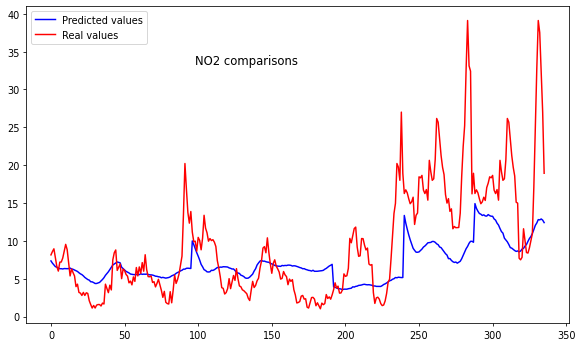

In [190]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(pred_norm[0][0:336], "-b", label="Predicted values")
plt.plot(grnd_norm[0][0:336], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()

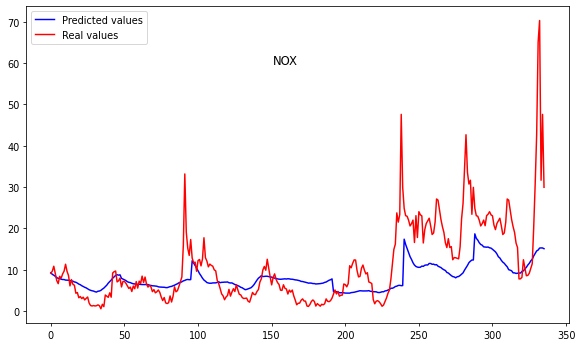

In [191]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(pred_norm[1][0:336], "-b", label="Predicted values")
plt.plot(grnd_norm[1][0:336], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NOX',  x=0.5, y=0.8, loc='right')
plt.show()

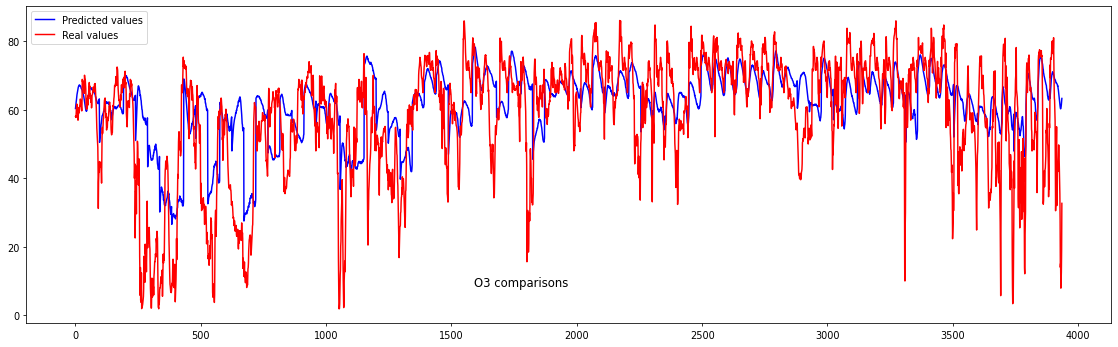

In [180]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_norm[2], "-b", label="Predicted values")
plt.plot(grnd_norm[2], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('O3 comparisons',  x=0.5, y=0.1, loc='right')
plt.show()

In [181]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[3], "-b", label="Predicted values")
plt.plot(grnd_de_norm[3], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('PM2.5 comparisons', y=0.5, loc='right')
plt.show()

KeyError: 3

<Figure size 1400x420 with 0 Axes>